# Focus: Texture

In [1]:
import kagglehub
import pandas as pd # to work with dataframes, manipulate data (panel data)
import matplotlib.pyplot as plt # viz library
import seaborn as sns # HD viz library
import numpy as np # to work with numbers (numerical python)
from scipy.stats import chi2_contingency
from scipy.stats.contingency import association
from scipy.stats import pearsonr

%matplotlib inline
pd.set_option('display.max_columns', None)

data = pd.read_csv(r'cleaned_data.csv')
df = data.copy()

c:\ProgramData\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Specifying only texture related columns

In [2]:
df_tex = df[['id', 'diagnosis','texture_mean', 'texture_se', 'texture_worst' ]]

### Defining a new value column

Idea: Add a new value for the difference between mean texture and texture at worst to explore possible correlation focusing the change of size

In [3]:
# defining a new measure for the difference between the mean and the worst texturees
df_tex = df_tex.assign( texture_diff = lambda x: (x['texture_worst'] - x['texture_mean'] ))
df_tex

,id,diagnosis,texture_mean,texture_se,texture_worst,texture_diff
0,842302,M,10.38,0.9053,17.33,6.95
1,842517,M,17.77,0.7339,23.41,5.64
2,84300903,M,21.25,0.7869,25.53,4.28
3,84348301,M,20.38,1.1560,26.50,6.12
4,84358402,M,14.34,0.7813,16.67,2.33
...,...,...,...,...,...,...
564,926424,M,22.39,1.2560,26.40,4.01
565,926682,M,28.25,2.4630,38.25,10.00
566,926954,M,28.08,1.0750,34.12,6.04
567,927241,M,29.33,1.5950,39.42,10.09


In [4]:
# filtering the DataFrame by diagnosis
df_M = df_tex[df_tex['diagnosis'] == 'M']
df_B = df_tex[df_tex['diagnosis'] == 'B']

In [5]:
# list of texture variables to compare
texture_vars = ['texture_mean', 'texture_se', 'texture_worst', 'texture_diff']

### Texture histograms and overview

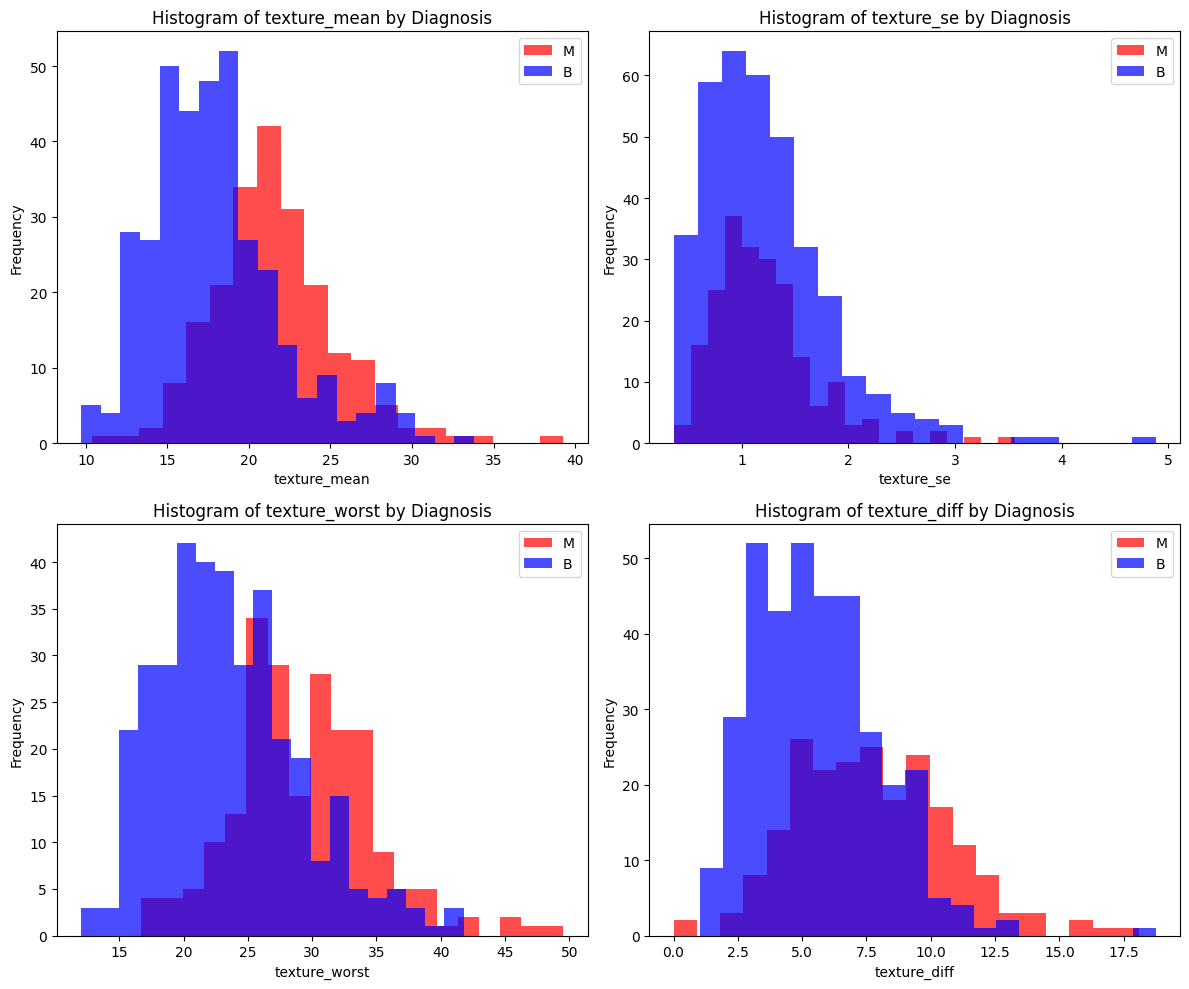

In [6]:
# 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# loop through each texture variable and plot overlapping histograms for "M" and "B"
for i, var in enumerate(texture_vars):
    ax = axes[i // 2, i % 2]
    # filtering data by diagnosis
    data_M = df_tex[df_tex['diagnosis'] == 'M'][var]
    data_B = df_tex[df_tex['diagnosis'] == 'B'][var]
    
    # plot overlapping histograms with same style and colors:
    # diagnosis M in red and diagnosis B in blue, with alpha=0.7
    ax.hist(data_M, bins=20, alpha=0.7, label='M', color='red')
    ax.hist(data_B, bins=20, alpha=0.7, label='B', color='blue')
    
    ax.set_title(f"Histogram of {var} by Diagnosis")
    ax.set_xlabel(var)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.savefig('plots/histo_texture.png')
plt.show()


### Closer look at the overlapping regions

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\776519332.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\776519332.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\776519332.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curre

texture_mean_bin
(10.379000000000001, 12.723]    0.117647
(12.723, 15.066]                0.040000
(15.066, 17.409]                0.172727
(17.409, 19.752]                0.307087
(19.752, 22.095]                0.594595
(22.095, 24.438]                0.714286
(24.438, 26.781]                0.694444
(26.781, 29.124]                0.478261
(29.124, 31.467]                0.444444
(31.467, 33.81]                 0.666667
Name: diagnosis, dtype: float64
texture_se_bin
(0.361, 0.683]    0.250000
(0.683, 1.003]    0.413333
(1.003, 1.324]    0.436620
(1.324, 1.644]    0.388350
(1.644, 1.965]    0.313725
(1.965, 2.286]    0.318182
(2.286, 2.606]    0.222222
(2.606, 2.927]    0.222222
(2.927, 3.247]    0.500000
(3.247, 3.568]    1.000000
Name: diagnosis, dtype: float64
texture_worst_bin
(16.669, 19.181]    0.129630
(19.181, 21.692]    0.078947
(21.692, 24.203]    0.216867
(24.203, 26.714]    0.414141
(26.714, 29.225]    0.460526
(29.225, 31.736]    0.737705
(31.736, 34.247]    0.651163
(34

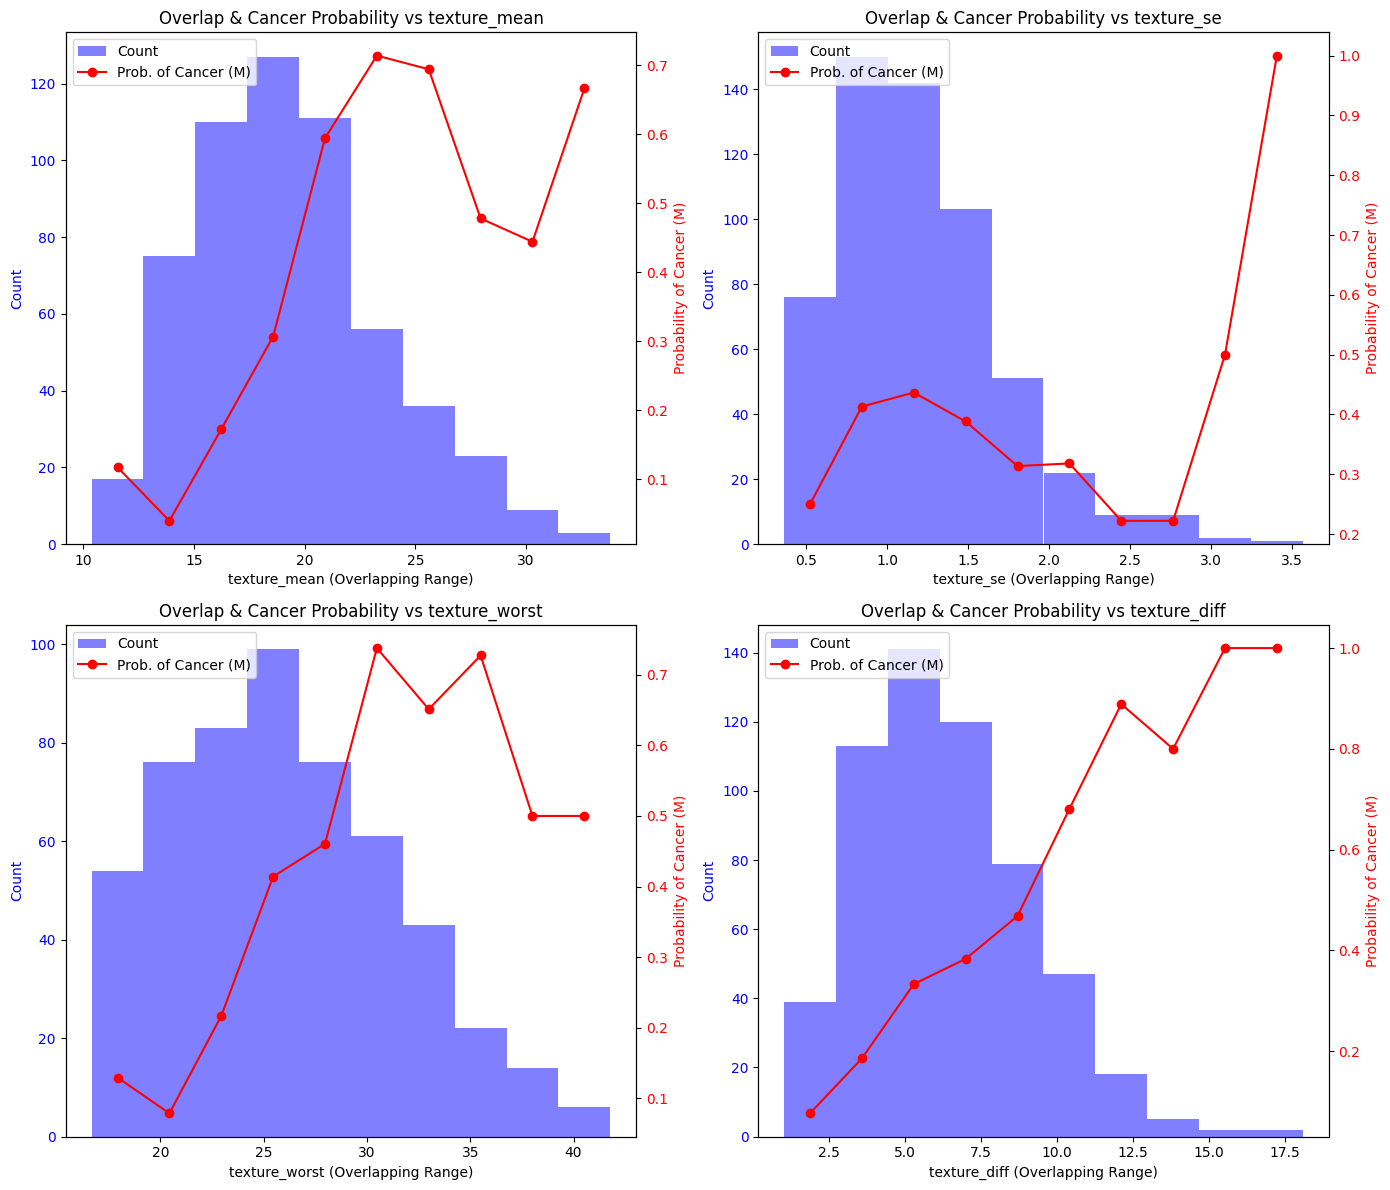

In [7]:
#  2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))
axes = axes.flatten()

# loop over each texture variable
for i, var in enumerate(texture_vars):
    
    # determine the overlapping range for the variable
    min_overlap = max(df_M[var].min(), df_B[var].min())
    max_overlap = min(df_M[var].max(), df_B[var].max())
    
    # filter the DataFrame to the overlapping region
    df_overlap = df_tex[(df_tex[var] >= min_overlap) & (df_tex[var] <= max_overlap)].copy()
    
    # create 10 evenly spaced bins in the overlapping range
    bins = np.linspace(min_overlap, max_overlap, 11)
    df_overlap[var + '_bin'] = pd.cut(df_overlap[var], bins=bins, include_lowest=True)
    
    # calculate counts for each bin and the probability of diagnosis "M"
    bin_counts = df_overlap.groupby(var + '_bin')['diagnosis'].count()
    prob_cancer = df_overlap.groupby(var + '_bin')['diagnosis'].apply(lambda x: (x == 'M').sum() / len(x))
    print(prob_cancer)
    
    # calculate bin centers and bin width
    bin_centers = [interval.mid for interval in bin_counts.index.categories]
    bin_width = bins[1] - bins[0]
    
    # plot on the current subplot
    ax = axes[i]
    # histogram (bar chart) for counts on primary y-axis (blue)
    ax.bar(bin_centers, bin_counts, width=bin_width, alpha=0.5, color='blue', label='Count')
    ax.set_xlabel(f"{var} (Overlapping Range)")
    ax.set_ylabel("Count", color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    ax.set_title(f"Overlap & Cancer Probability vs {var}")
    
    # create a secondary y-axis for the probability curve (red)
    ax2 = ax.twinx()
    ax2.plot(bin_centers, prob_cancer.values, marker='o', linestyle='-', color='red', label='Prob. of Cancer (M)')
    ax2.set_ylabel("Probability of Cancer (M)", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    

    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('plots/histo_overlap_texture.png')
plt.show()


### Boxplot overview of 4 texture metrics

C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\1683533087.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_tex,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\1683533087.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_tex,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\1683533087.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='diagnosis', y=var, data=df_tex,
C:\Users\Vanuhi\AppData\Local\Temp\ipykernel_1508\1683533087.py:8: FutureWarning: 

Passing `palette` w

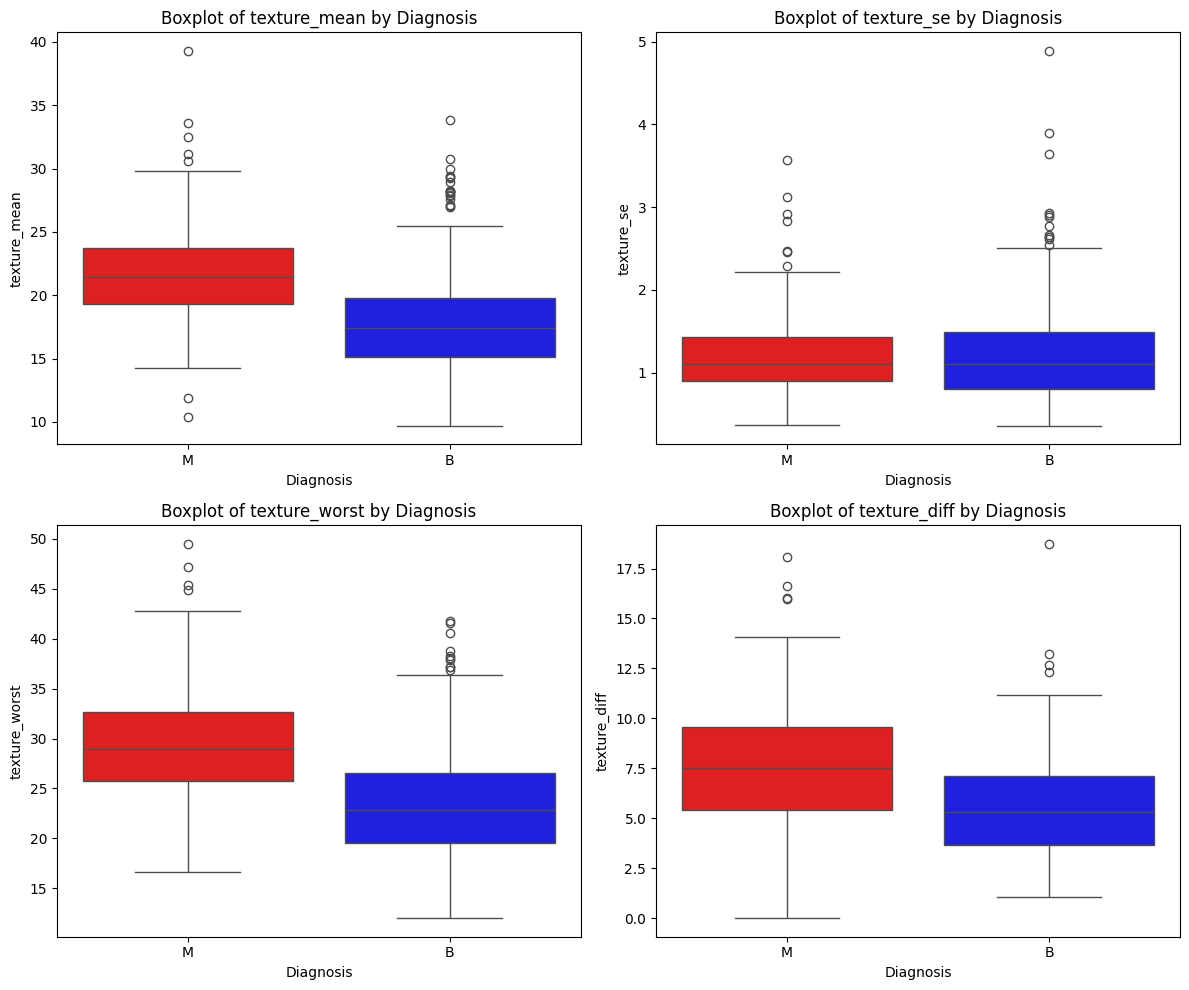

In [8]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten the axes array so each element is an Axes instance

# Loop over each variable and generate a boxplot
for i, var in enumerate(texture_vars):
    ax = axes[i]
    sns.boxplot(x='diagnosis', y=var, data=df_tex,
                palette={'M': 'red', 'B': 'blue'}, ax=ax)
    ax.set_title(f"Boxplot of {var} by Diagnosis")
    ax.set_xlabel("Diagnosis")
    ax.set_ylabel(var)

plt.tight_layout()
plt.savefig('plots/boxplt_texture.png')
plt.show()


Pearson's correlation for texture_mean, texture_se, texture_worst and texture_diff with diagnosis

In [9]:
df_tex['diagnosis_numeric'] = df_tex['diagnosis'].map({'B': 0, 'M': 1})

# list of texture variables to analyze
textures_columns = ['texture_mean', 'texture_se', 'texture_worst', 'texture_diff']

# dictionary for correlation results
results = {}

for col in textures_columns:
    r, p = pearsonr(df_tex['diagnosis_numeric'], df_tex[col])
    results[col] = {'p-value': p, 'r-Pearson': r}

results_df = pd.DataFrame(results).T
print(results_df)


                    p-value  r-Pearson
texture_mean   4.058636e-25   0.415185
texture_se     8.433320e-01  -0.008303
texture_worst  1.078057e-30   0.456903
texture_diff   7.007864e-19   0.360275


Texture mean and max(_worst) show the closest to 0 values, indicating strong correlation

### Chi-Square for the overlapping region for diagnosis and texture at worst

Let's pick the texture metric with the smallest p-value and calculate its Chi-Square p-value.

Since the texture is a continues numeric data, first converting it into discrete values within the overlapping region using binning technique and then calculating p-value of Chi-Square

In [10]:
# determining overlapping range
min_overlap = max(df_M['texture_worst'].min(), df_B['texture_worst'].min())
max_overlap = min(df_M['texture_worst'].max(), df_B['texture_worst'].max())

df_overlap = df_tex[(df_tex['texture_worst'] >= min_overlap) & (df_tex['texture_worst'] <= max_overlap)]

# bins for the overlapping region (10 bins)
bins = np.linspace(min_overlap, max_overlap, 11)
df_overlap = df_overlap.copy()  # avoid SettingWithCopyWarning
df_overlap['texture_bin'] = pd.cut(df_overlap['texture_worst'], bins=bins, include_lowest=True)


contingency_table = pd.crosstab(df_overlap['texture_bin'], df_overlap['diagnosis'])
print(contingency_table)


_,pvalue, _, _ = chi2_contingency(contingency_table)
cramer_v = association(contingency_table, method='cramer')
print(f'Chi-Square p-value is {pvalue}\nCramer V is: {cramer_v}')


diagnosis          B   M
texture_bin             
(16.669, 19.181]  47   7
(19.181, 21.692]  70   6
(21.692, 24.203]  65  18
(24.203, 26.714]  58  41
(26.714, 29.225]  41  35
(29.225, 31.736]  16  45
(31.736, 34.247]  15  28
(34.247, 36.758]   6  16
(36.758, 39.269]   7   7
(39.269, 41.78]    3   3
Chi-Square p-value is 2.3972209731495563e-20
Cramer V is: 0.4617685128830208


Although the chi-square test produced a statistically significant p-value, the corresponding Cramér's V value remained below 0.5. This suggests that the texture metric does not exhibit a strong correlation or association relative to the other metrics under evaluation.